In [30]:
import random  # Random number generator
import pickle  # Object serialization

import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization

import tensorflow.keras.utils as ku  # Keras utility functions
from wordcloud import WordCloud  # Word cloud generation
from sklearn.model_selection import train_test_split  # Data splitting

from tensorflow.keras.preprocessing.sequence import pad_sequences  # Sequence padding
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization  # Neural network layers
from tensorflow.keras.preprocessing.text import Tokenizer  # Text preprocessing
from tensorflow.keras.models import Sequential, load_model  # Neural network models
from tensorflow.keras.optimizers import Adam  # Optimization algorithms
from tensorflow.keras import regularizers  # Regularization techniques
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Callbacks for model training

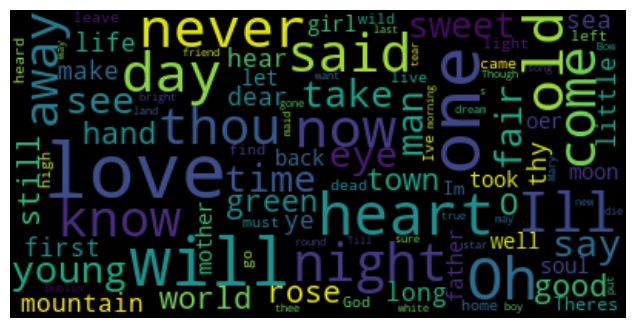

In [3]:
# Reading the text data file
data = open('data/poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [4]:
type(data)

str

In [5]:
data

'Stay, I said\nto the cut flowers.\nThey bowed\ntheir heads lower.\nStay, I said to the spider,\nwho fled.\nStay, leaf.\nIt reddened,\nembarrassed for me and itself.\nStay, I said to my body.\nIt sat as a dog does,\nobedient for a moment,\nsoon starting to tremble.\nStay, to the earth\nof riverine valley meadows,\nof fossiled escarpments,\nof limestone and sandstone.\nIt looked back\nwith a changing expression, in silence.\nStay, I said to my loves.\nEach answered,\nAlways.\nTwo sets\nof family stories,\none long and detailed,\nabout many centuries\nof island ancestors, all living\non the same tropical farm...\nThe other side of the family tells stories\nthat are brief and vague, about violence\nin the Ukraine, which Dad\'s parents\nhad to flee forever, leaving all their\nloved ones\nbehind.\nThey don\'t even know if anyone\nsurvived.\nWhen Mami tells her flowery tales of Cuba,\nshe fills the twining words with relatives.\nBut when I ask my\nUkrainian-Jewish-American grandma\nabout her

In [6]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [7]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 3807


In [14]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


In [15]:
input_sequences

array([[   0,    0,    0, ...,    0,  266,    3],
       [   0,    0,    0, ...,  266,    3,   59],
       [   0,    0,    0, ...,    0,    4,    1],
       ...,
       [   0,    0,    0, ..., 3807,   15,    4],
       [   0,    0,    0, ...,   15,    4,  203],
       [   0,    0,    0, ...,    4,  203,   85]], dtype=int32)

In [16]:
# predictors
input_sequences[:, :-1]

array([[   0,    0,    0, ...,    0,    0,  266],
       [   0,    0,    0, ...,    0,  266,    3],
       [   0,    0,    0, ...,    0,    0,    4],
       ...,
       [   0,    0,    0, ...,    8, 3807,   15],
       [   0,    0,    0, ..., 3807,   15,    4],
       [   0,    0,    0, ...,   15,    4,  203]], dtype=int32)

In [17]:
# label
input_sequences[:, -1]

array([  3,  59,   1, ...,   4, 203,  85], dtype=int32)

In [18]:
max_sequence_len

16

In [19]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
print(predictors.shape)
print(label.shape)

(16311, 15)
(16311, 3808)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(predictors, label, test_size=0.25, random_state=42)

In [93]:
sequence_len = predictors.shape[1] # max_sequence_len = max([len(x) for x in input_sequences])
sequence_len

15

In [54]:
def create_model(total_words,sequence_len):
    """
    Creates LSTM model for text generation.

    Args:
        total_words (int): The total number of unique words in the vocabulary.
        sequence_len (int): The length of input sequences (number of tokens).

    Returns:
        keras.models.Sequential: The created bidirectional LSTM model.

    """
    model = Sequential()
    model.add(Embedding(input_dim=total_words,output_dim=sequence_len,input_length=sequence_len))
    model.add(LSTM(units=150,return_sequences=True))
    model.add(LSTM(units=150,return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(LSTM(units=300))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(units=150,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(units=total_words,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics='accuracy')
    
    model.summary()
    return model

In [58]:
model = create_model(total_words+1,sequence_len)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 15)            57120     
                                                                 
 lstm_4 (LSTM)               (None, 15, 150)           99600     
                                                                 
 lstm_5 (LSTM)               (None, 15, 150)           180600    
                                                                 
 batch_normalization (BatchN  (None, 15, 150)          600       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 15, 150)           0         
                                                                 
 lstm_6 (LSTM)               (None, 300)               541200    
                                                      

In [62]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=300,verbose=1,mode='max',restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=10,mode='max',factor=0.1,min_lr=0.001,verbose=1)
model_checkpoint = ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True,verbose=1)

r = model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=150,
          verbose=2,
          validation_data=(X_test,y_test),
          callbacks=[model_checkpoint,reduce_lr,early_stopping])

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.03188, saving model to checkpoint/
96/96 - 19s - loss: 8.1584 - accuracy: 0.0139 - val_loss: 7.9199 - val_accuracy: 0.0319 - lr: 0.0010 - 19s/epoch - 196ms/step
Epoch 2/300

Epoch 2: val_accuracy did not improve from 0.03188
96/96 - 4s - loss: 7.4837 - accuracy: 0.0464 - val_loss: 7.3625 - val_accuracy: 0.0319 - lr: 0.0010 - 4s/epoch - 43ms/step
Epoch 3/300

Epoch 3: val_accuracy improved from 0.03188 to 0.06130, saving model to checkpoint/
96/96 - 4s - loss: 6.7023 - accuracy: 0.0645 - val_loss: 7.2084 - val_accuracy: 0.0613 - lr: 0.0010 - 4s/epoch - 43ms/step
Epoch 4/300

Epoch 4: val_accuracy improved from 0.06130 to 0.06302, saving model to checkpoint/
96/96 - 2s - loss: 6.3005 - accuracy: 0.0791 - val_loss: 7.2723 - val_accuracy: 0.0630 - lr: 0.0010 - 2s/epoch - 25ms/step
Epoch 5/300

Epoch 5: val_accuracy did not improve from 0.06302
96/96 - 3s - loss: 6.0419 - accuracy: 0.0922 - val_loss: 7.4100 - val_accuracy: 0.0630 - 

In [94]:
# Save training history
with open('training_history_lstm.pickle', 'wb') as file:
    pickle.dump(r.history, file)

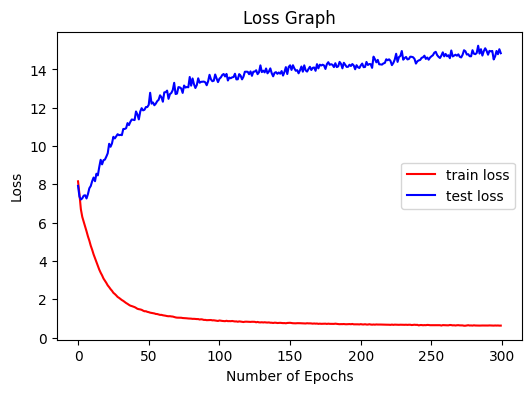

In [67]:
plt.figure(figsize=(6,4))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

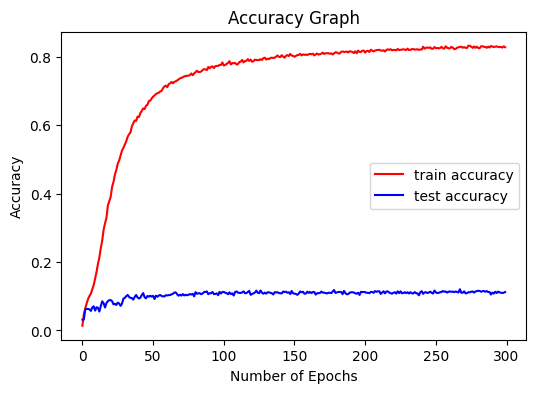

In [68]:
plt.figure(figsize=(6,4))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [69]:
model.evaluate(X_test,y_test)

128/128 [==============================] - 1s 6ms/step - loss: 14.8459 - accuracy: 0.1126


[14.845913887023926, 0.11255517601966858]

In [71]:
model.save('model2_lstm.h5')

In [72]:
lstm = load_model('model2_lstm.h5')
lstm

In [73]:
def generate_text(model,tokenizer,sequence_len,seed_text,num_words):
    output_text = []
    input_text = seed_text
    
    for i in range(num_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        padded_text = pad_sequences([encoded_text],maxlen=sequence_len,truncating='pre')
        predictions = model.predict(padded_text,verbose=0)[0]
        pred_word = tokenizer.index_word[predictions.argmax()]
        input_text += ' ' + pred_word
        output_text.append(pred_word)
    
    return ' '.join(output_text)

In [91]:
for i in range(10):
    random_sequence = input_sequences[random.randint(0, len(input_sequences))]
    random_seed_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in random_sequence])
    print(f'{random_seed_text}: ')
    print(f'{generate_text(lstm, tokenizer, sequence_len, random_seed_text, num_words=25)}\n\n')

           myself got a lick from: 
big phelim mchugh alone alone or so bow lives me with say true said she was true fly to beat on me fast asleep wonder


       when the climate is raw and the gun makes: 
law law though the wearin o the green and smiling heart my pike in wonder fray fray fray up the row in dublin was of


            action along with error: 
growth along along the high ones up the sea and the sea of the green of true again so power the daylight of dublin whack


          with aching bone and sinew conscious: 
of things amiss amiss amiss power of wid i quart its sinking dew on the bars wid you know me that i would not alone


             if you have: 
been opened a pike of a father there was in doneen one's hands— thyme say da dying of the light of each auld rigadoo no


           oh oh oh oh i: 
wish i you back home he derry derry ago his quay pike oer the sight air he heart of his power of wid her tears


        ill drink good health to the creole girl: 
he was

In [98]:
seed_text = "myself got a lick from"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

myself got a lick from big phelim mchugh alone alone or so bow lives me with say true said she was true fly to beat on me fast asleep wonder


In [31]:
# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the model
model.save('model.h5')

# Save training history
with open('history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
# Save training history
with open('training_history_lstm.pickle', 'wb') as file:
    pickle.dump(r.history, file)

# ...........................

# # Load the tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# # Load the model
# model = load_model('model.h5')

# # Load the history
# with open('history.pickle', 'rb') as handle:
#     history = pickle.load(handle)